In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, models
import torchvision.transforms as transforms
from datetime import datetime
from torch.utils import data
import random
from PIL import Image
import warnings
import shap
warnings.filterwarnings("ignore")

In [53]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [54]:
#transform the images to the default input shape 224x224
transform = transforms.Compose([transforms.Resize([224, 224]), transforms.ToTensor()])
data_set = datasets.ImageFolder(root = 'new_data', transform = transform, loader = default_loader)
n = len(data_set)
n_test = int( n * .2 )
n_train = n - n_test

In [55]:
# train, test split
train_set, test_set = data.random_split(data_set, (n_train, n_test))

In [56]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True, num_workers=15)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True, num_workers=15)

In [57]:
#Select 10 random images of each class.
path = 'new_data/'
num_files_per_folder = [len(files) for root, dirs, files in os.walk('new_data') if len(files) > 0]
folders = [dirs for root, dirs, files in os.walk('new_data') if len(dirs) > 0][0]
filenames = [os.listdir('new_data/' + folder) for folder in folders]
files = [np.random.choice(files, 10, replace = False) for files, num_files in zip(filenames, num_files_per_folder)]

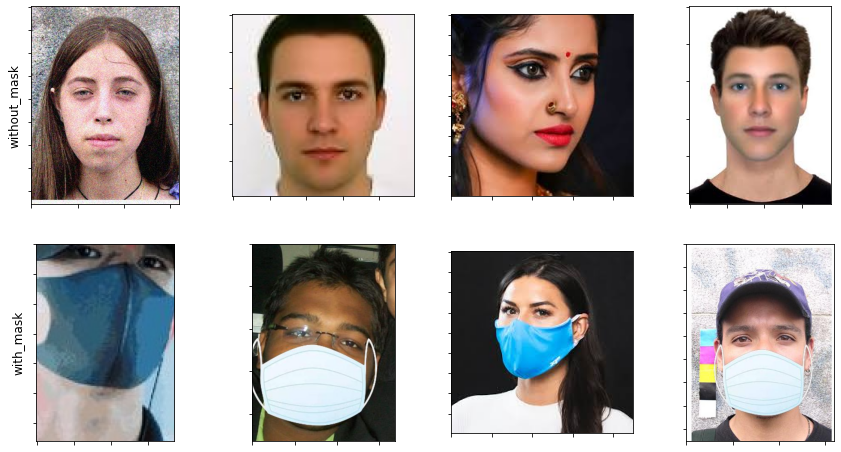

In [58]:
fig, ax = plt.subplots(2, 4, figsize = (15, 8))
for row in range(2):
    category = folders[row]
    ax_row = ax[row]
    for column in range(4):
        img = plt.imread(path + category + '/' + files[row][column])
        ax_column = ax_row[column]
        ax_column.imshow(img, cmap='gray')
        if column == 0:
            ax_column.set_ylabel(category, size = 'large')
        ax_column.set_xticklabels([])
        ax_column.set_yticklabels([])

In [59]:
#downloading the pretrained model
model = models.vgg16(weights = 'VGG16_Weights.DEFAULT')

In [60]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [61]:
n_inputs = model.classifier[6].in_features
classification_layer = nn.Linear(n_inputs, len(train_set.dataset.classes))
model.classifier[6] = classification_layer

In [62]:
n_inputs, len(train_set.dataset.classes)

(4096, 2)

In [63]:
for param in model.features.parameters():
    param.requires_grad = False

In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [65]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')
model.to(device)

Device: cpu


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [66]:
def training_loop(loader, epoch):
    
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()


        predicted = torch.argmax(F.softmax(outputs, dim = 1), dim = 1)
        
        
        equals = predicted == labels
        
        
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy

        if i %50 == 0:
            
            print(f'Epoch: {epoch+1} | loop {i+1}/{len(loader)} Loss: {loss.item():.5f} - Accuracy: {accuracy:.5f}')
        

    print(f'>>>>> Epoch: {epoch+1} Loss: {running_loss/len(loader):.5f} - Accuracy: {running_accuracy/len(loader):.5f}')

In [66]:
%%time 
for epoch in range(3):
    print('Training...')
    training_loop(train_loader, epoch)
    model.eval()
    print('Validation...')
    training_loop(test_loader, epoch)
    model.train()

torch.save(model.state_dict(), 'mask_detection_model')
model_scripted = torch.jit.script(model)
model_scripted.save('mask_detection_model.pt')

Training...
Epoch: 1 | loop 1/48 Loss: 0.00094 - Accuracy: 1.00000
>>>>> Epoch: 1 Loss: 0.01634 - Accuracy: 0.99707
Validation...
Epoch: 1 | loop 1/12 Loss: 0.00009 - Accuracy: 1.00000
>>>>> Epoch: 1 Loss: 0.00402 - Accuracy: 0.99870
Training...
Epoch: 2 | loop 1/48 Loss: 0.00007 - Accuracy: 1.00000
>>>>> Epoch: 2 Loss: 0.01284 - Accuracy: 0.99788
Validation...
Epoch: 2 | loop 1/12 Loss: 0.01814 - Accuracy: 0.99219
>>>>> Epoch: 2 Loss: 0.00324 - Accuracy: 0.99870
Training...
Epoch: 3 | loop 1/48 Loss: 0.00000 - Accuracy: 1.00000
>>>>> Epoch: 3 Loss: 0.01113 - Accuracy: 0.99772
Validation...
Epoch: 3 | loop 1/12 Loss: 0.02807 - Accuracy: 0.99219
>>>>> Epoch: 3 Loss: 0.01045 - Accuracy: 0.99870
CPU times: user 49 s, sys: 3.5 s, total: 52.5 s
Wall time: 1min 42s


In [67]:
model = torch.jit.load('mask_detection_model.pt', map_location=device)

In [38]:
# Set the model to evaluation mode
model.eval()

# Initialize some variables for keeping track of the predictions and accuracy
predictions = []
targets = []
accuracy = 0

# Loop over the test dataset, making predictions for each image
for inputs, labels in test_loader:
    # Move the inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Disable gradient computation for inference
    with torch.no_grad():
        # Make a prediction for the input batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
    
    # Append the predicted and actual labels to the lists
    predictions.extend(predicted.cpu().numpy())
    targets.extend(labels.cpu().numpy())
    
    # Update the accuracy if the prediction is correct
    accuracy += torch.sum(predicted == labels).item()

# Compute the overall accuracy
accuracy /= len(test_set)
accuracy *= 100

# Print the accuracy
print(f'Accuracy: {accuracy}%')

# Get predictions and targets for a batch of images
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.cpu().numpy()

# Make predictions for the batch
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

# Convert the predictions and targets to numpy arrays
predicted = predicted.cpu().numpy()

# Print the predictions and targets for the first 10 images in the batch
print('Example predictions:')
for i in range(10):
    print(f'Prediction: {predicted[i]}, Target: {labels[i]}')


Accuracy: 99.80132450331126%
Example predictions:
Prediction: 1, Target: 1
Prediction: 0, Target: 0
Prediction: 1, Target: 1
Prediction: 1, Target: 1
Prediction: 0, Target: 0
Prediction: 1, Target: 1
Prediction: 1, Target: 1
Prediction: 1, Target: 1
Prediction: 1, Target: 1
Prediction: 1, Target: 1


In [68]:
images = images.permute(0, 2, 3, 1).numpy()
images.shape

(128, 224, 224, 3)

In [69]:
idx_to_class = {k: v for v, k in test_set.dataset.class_to_idx.items()}
labels = [idx_to_class[label] for label in labels]
predicted = [idx_to_class[label] for label in predicted]

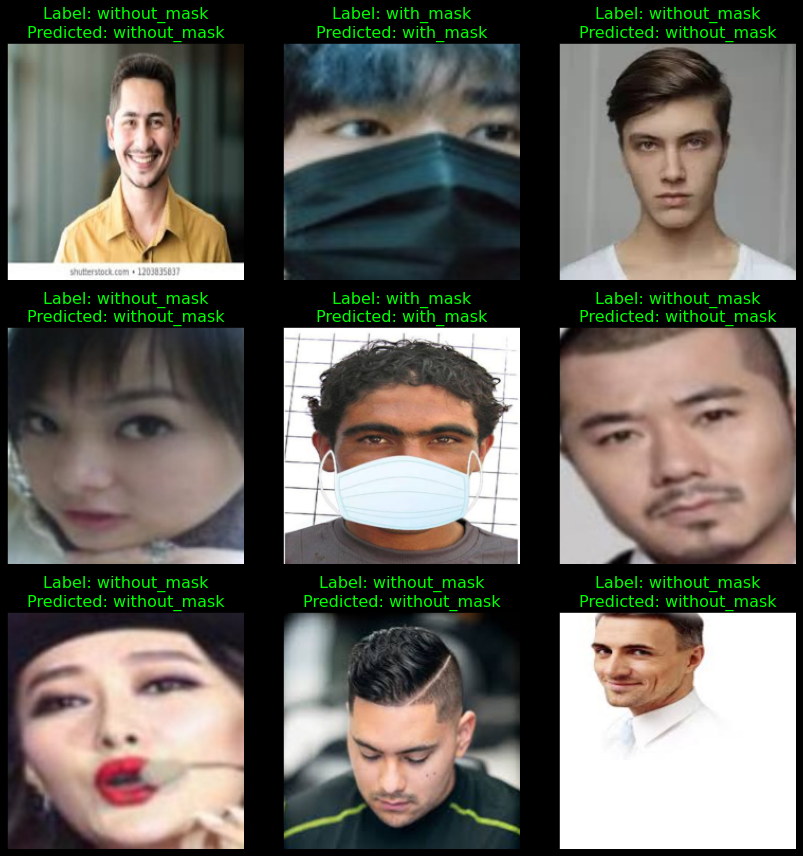

In [71]:
import matplotlib.pyplot as plt

# Plotting the results
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.2)  # Add some padding between the images
fig.patch.set_facecolor('black')  # Set the figure background to black

i = 0
for row in range(3):
    for column in range(3):
        ax_column = ax[row, column]
        ax_column.imshow(images[i])
        ax_column.tick_params(axis='both', which='both', length=0)  # Remove ticks
        ax_column.set_xticklabels([])
        ax_column.set_yticklabels([])
        col = 'lime' if labels[i] == predicted[i] else 'red'  # Change the color for better visibility
        ax_column.set_title(f'Label: {labels[i]}\nPredicted: {predicted[i]}', color=col, fontsize=16)
        ax_column.set_facecolor('black')  # Set the background of each subplot to black
        i += 1

plt.tight_layout()
plt.show()